# 0. 환경 세팅

```
YOLO11/
├── data/                             
│   ├── animals/                       
│   │   ├── dog/                     
│   │   ├── cat/                      
│   │   └── rabbit/                  
│   ├── Animals2.v2i.yolov11/         # Roboflow에서 라벨링된 학습/검증 데이터셋 넣는 곳
│   ├── example.jpeg                 
│   └── example_result.jpeg          
│
├── runs/                             # 모델 학습 및 추론 결과 저장 폴더 (코드 실행 시 자동 생성)
│   └── detect/
│       ├── predict/              
│       ├── train/                
│       └── val/                  
│
├── YOLO_practice.ipynb          
├── screenshot1.png                   
├── screenshot2.png
├── screenshot3.png
└── yolo11m.pt                        # 사전학습된 YOLO 모델 다운 후 저장 경로

```

In [3]:
import torch
torch.backends.mps.is_available() # GPU 사용 가능 여부 확인

True

In [4]:
import gc
gc.collect() # 메모리 정리

20

# 1. 데이터 다운로드 (Unplash API 사용)

Unplash API (https://unsplash.com/developers)를 사용해서 dog, cat, rabbit 이미지를 각각 30장씩 다운로드 했습니다. </br>

In [2]:
import os
import requests
from PIL import Image
from io import BytesIO
import time

# Unsplash API access key (발급받은 키로 교체)
ACCESS_KEY = "YOUR_ACCESS_KEY_HERE"

# 동물 목록과 저장 위치 설정
animals = ["dog", "cat", "rabbit"]
base_dir = "./data/animals"
per_page = 30  # 요청당 최대 이미지 수 (Unsplash 최대값)

def download_unsplash_images(animal, save_dir, access_key, num_images=30):
    os.makedirs(save_dir, exist_ok=True)
    count = 0
    page = 1

    print(f"📥 {animal} 다운로드 시작...")

    while count < num_images:
        url = "https://api.unsplash.com/search/photos"
        params = {
            "query": animal,
            "per_page": min(per_page, num_images - count),
            "page": page,
            "client_id": access_key
        }

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"❌ API 오류: {response.status_code} - {response.text}")
            break

        results = response.json().get("results", [])
        if not results:
            print(f"⚠️ 더 이상 이미지가 없습니다. {count}장만 다운로드됨.")
            break

        for i, result in enumerate(results):
            img_url = result["urls"]["regular"]
            try:
                img_data = requests.get(img_url, timeout=10).content
                img = Image.open(BytesIO(img_data)).convert("RGB")
                filename = os.path.join(save_dir, f"{animal}_{count + 1}.jpg")
                img.save(filename)
                count += 1
                time.sleep(0.5)  # 과도한 요청 방지 (API rate limit 대비)
                if count >= num_images:
                    break
            except Exception as e:
                print(f"⚠️ 이미지 저장 실패: {e}")
                continue

        page += 1

    print(f"🎉 {animal}: 총 {count}장 저장 완료 ({save_dir})\n")


# 전체 동물 이미지 다운로드 실행
for animal in animals:
    save_path = os.path.join(base_dir, animal)
    download_unsplash_images(animal, save_path, ACCESS_KEY, num_images=30)


📥 dog 다운로드 시작...
🎉 dog: 총 30장 저장 완료 (./data/animals/dog)

📥 cat 다운로드 시작...
🎉 cat: 총 30장 저장 완료 (./data/animals/cat)

📥 rabbit 다운로드 시작...
🎉 rabbit: 총 30장 저장 완료 (./data/animals/rabbit)



# 2. YOLO model training

모델 코드 참고: https://docs.ultralytics.com/ko/

## 모델 불러오기 (YOLO11m)

In [8]:
from ultralytics import YOLO

model = YOLO("yolo11m.pt")

## 모델 사용해보기


image 1/1 /Users/skku_aws24/Desktop/CHS/cursor/YOLO/data/example.jpeg: 640x640 1 dog, 182.3ms
Speed: 1.7ms preprocess, 182.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


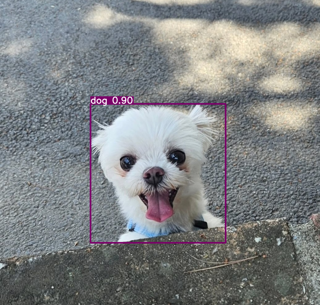

In [9]:
results = model.predict(source="data/example.jpeg") # YOLO에 아무 이미지 하나를 넣어보기

for result in results:
    img_with_boxes = result.plot()
    show_img = Image.fromarray(img_with_boxes[..., ::-1])  # PIL Image로 변환 (BGR → RGB)
    show_img = show_img.resize((320, int(320 * show_img.height / show_img.width))) # 이미지 크기 조절
    display(show_img) # 추론 결과를 보여주기
    show_img.save("data/example_result.jpeg") # 추론 결과를 저장하기

강아지를 잘 인식하는 것을 볼 수 있다.

## 'data/animal' 폴더의 데이터 라벨링, annotation

1번에서 다운로드한 이미지 데이터를 그대로 모델에 학습시킬 수도 있지만, 이 경우 실제 동물 이외의 배경이나 불필요한 영역까지 함께 학습되어 모델 성능이 저하될 수 있다. </br>
따라서 Roboflow (https://roboflow.com/)를 활용해 동물 부분만 학습에 사용할 수 있도록 전처리해보자.

```
1. Roboflow 회원가입 후 로그인한다.
2. Create new project > object detection > 'data/animal'폴더를 통째로 업로드 > save and continue.
3. 파일 업로드가 완료되면 start labeling을 누르고 라벨링 작업을 진행한다. 여러명이 나눠서 작업을 같이 할 수도 있다.
```

<img src="data/screenshot1.png" width="600"/>

```
4. 라벨링을 완료하면 데이터 셋을 만든다. 본인이 원하는대로 data split, preprocessing, augmentation을 진행한다.
```

<img src="data/screenshot2.png" width="400"/>

```
5. 완성한 데이터셋은 zip파일로 다운받거나, API로 다운받을 수 있다. 본 실습에선 zip파일로 다운받고 해당 경로에 저장했다 (0. 환경 세팅 참고).
* 다운로드 시, Image and Annotation Format에서 yolo11 버전을 선택하자.
```

## YOLO 모델에 라벨링한 이미지 training

```
모델 training에 앞서, 'data/Animals.v2i.yolov11/data.yaml' 이 파일을 다음과 같이 수정하였다.

수정 전
train: ../train/images
val: ../valid/images
test: ../test/images

수정 후
train: ./train/images
val: ./valid/images
test: ./test/images
```

In [ ]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')
results = model.train(data='data/Animals2.v1i.yolov11/data.yaml', 
                      epochs=20, 
                      imgsz=640,
                      device='mps',
                      batch=16)

# 3. 모델 평가

Training을 진행하고 나면 'runs/detect/train/weights/best.pt' 가 생성된다. </br>
학습된 모델에 validation 데이터를 넣어서 평가해본다.

In [ ]:
from ultralytics import YOLO
model = YOLO('runs/detect/train/weights/best.pt') # Load the best model

metrics = model.val(data='data/Animals2.v1i.yolov11/data.yaml', batch=18, imgsz=640, device="mps")

Ultralytics 8.3.161 🚀 Python-3.12.10 torch-2.7.1 MPS (Apple M4)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 346.1±73.6 MB/s, size: 83.1 KB)


val: Scanning /Users/skku_aws24/Desktop/CHS/cursor/YOLO/data/Animals2.v1i.yolov11/valid/labels.cache... 72 images, 0 backgrounds, 0 corrupt: 100%|██████████| 72/72 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


                   all         72         72      0.343      0.922      0.432      0.401
                   cat         32         32      0.387       0.79      0.495      0.468
                   dog         12         12       0.23          1      0.345      0.334
                rabbit         28         28      0.412      0.974      0.456      0.401
Speed: 3.2ms preprocess, 6.1ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to runs/detect/val


이번엔 테스트 데이터를 넣어서 모델이 어떻게 평가했는지를 확인해보자.

In [14]:
_ = model.predict(source='data/test/images', save=True, imgsz=640, device='mps', verbose=False)

Results saved to runs/detect/predict


모델이 예측한 결과물은 'runs/detect/predict'에 저장된다.

<img src="runs/detect/predict/tran-mau-tri-tam-7QjU_u2vGDs-unsplash_jpg.rf.7b02a0bd30c95a9fe132d9af5958f396.jpg" width="400"/>

정확도가 떨어지는걸 볼 수 있다. 원인은 모델 학습에 사용한 이미지 수가 적기 때문이다.